# EMAILS NETWORKS


In this case we align the for email networks from a University after filtering the suitable nodes to align (see Methods and Data).

There is information about the departments, so we introduce it as group information


In [1]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict

# DATASET 

Dataset after the filtering indicated in the main paper

In [2]:

d_store_upper = pickle.load(open("mails_07_10_upperthreshold_25_5links.pickle", "rb"))
schosen = "_some_some"
string = "M" + schosen
M_square_bin = d_store_upper[string]
tablas = M_square_bin.shape[0]
rows, columns = M_square_bin.shape[1] , M_square_bin.shape[2]


# Functions

Functions for computing the energy of the alignment

In [3]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):
    n1 = int(Edges_L + alpha + beta - 2)
    k1 = overlap_1 + alpha -1
    
    n0 = int(Edges_NoL + alpha + beta - 2)
    k0 = overlap_0 + alpha - 1
    
    # !!!! Numba [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(n1+1)- math.lgamma(k1+1) - math.lgamma(n1-k1 +1) + math.log( Edges_L + alpha+beta-1)
    H0 = math.lgamma(n0+1)- math.lgamma(k0+1) - math.lgamma(n0-k0 +1) + math.log( Edges_NoL + alpha+beta-1)
    
    H = H1 + H0

    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0, ovlp_1 = 0,0
    for k in range(0,K):
        for f in range(0,Ny):
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])           
            
                if (L_f[f,c] == A_f[k,p_f,p_c]): #Antes tenía esto al revés
                    if (L_f[f,c] == 1):
                        ovlp_1 = ovlp_1+1
                    else:
                        ovlp_0 = ovlp_0 +1

    return ovlp_0, ovlp_1

@jit(nopython=True)
#In each step the latent matrix is also stored
def L_wiring(A_f, P_inv_f):
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
                p1 = int(P_inv_f[k,i]) 
                p2 = int(P_inv_f[k,j]) 
                L_new_f[i,j] += A_f[k,p1,p2]
            # Each entry averaged over all the network
            valor_lnew=1/K* L_new_f[i,j]
            L_new_f[i,j] = round( valor_lnew )

    return L_new_f
    
#Este tiene en cuenta una lista secundaria
#(que puede ser por ejemplo el hub de mayor tamaño)
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    #print('dentro:',array, begin, end)
    if end is None:
        end = len(array) - 1
    if begin >= end: #Para acabar el algoritmo
        return
    pivot = partition(array,  etiquetas, begin, end)
    #print('pivot', pivot, 'array', array)
    
    #Aquí ordenamos la derecha y la izquierda
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
@njit 
# Ordering according the node degree taking into account the groups
def permu_groups(L_f, A_f, start_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    P_f=np.zeros((K,Nx))
    P_inv_f=np.zeros((K,Nx))
    P_new=np.zeros((K,Nx))
    
    #Ordering accroding node degree Latent
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size#.size
        
    array_L = np.arange(Nx)
    quicksort(orden_L, array_L)
    # Taking into account the groups
    array_L_labels = np.zeros((Nx))
    group_number = np.zeros((N_groups))
    for i in range(Nx):
        n_type = 0
        while ( (array_L[i] >= start_f[n_type]) and (n_type < N_groups)):
            n_type += 1
        grupo = int(n_type-1)
        g = int(start_f[grupo])
        array_L_labels[g + int(group_number[grupo])] = array_L[i]
        group_number[grupo] += 1

   
    #Ordering connectomes
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) 
        quicksort(orden_A, array_A)

        ## Groups
        array_A_labels = np.zeros((Nx))
        group_number = np.zeros((N_groups))
        
        for i_g in range(Nx):
            n_type = 0
            while ( (array_A[i_g] >= start_f[n_type]) and (n_type < N_groups) ):
                n_type += 1

            grupo = int(n_type-1)
            g = int(start_f[grupo])
            array_A_labels[ g + int(group_number[grupo])] = array_A[i_g]
            group_number[grupo] += 1

        array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        P_f[i,:] = array_A_labels
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

    
    return P_todo

@njit 
#In case we want random initialization
def random_groups(L_f, A_f, start_f, end_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    #Matrices permutación y sus inversas
    P_f=np.zeros((K,Nx))
    P_inv_f=np.zeros((K,Nx))
    P_new=np.zeros((K,Nx))
    
    for i in range(0,K):
        for i_g in range(N_groups):
            start = start_f[i_g]
            end = end_f[i_g]
            
            ordenado = np.arange(start, end)
            np.random.shuffle(ordenado)
            P_f[i,start:end] = ordenado
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv

    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

    
    
    return P_todo


# INITIAL CONDITIONS AND GROUPS

In [4]:
# This change of the name is because we had different filtering data
s = "start_groups" + schosen
start_groups = d_store_upper[s]
s = "end_groups" + schosen
end_groups = d_store_upper[s] 
s = "size_groups" + schosen
size_groups = d_store_upper[s]
s = "groups_users_names"
names_groups = d_store_upper[s] 
n_groups = len(size_groups)
print('SIZE GROUPS:', size_groups)


print('starting nodes by groups:', start_groups)
Nx, Ny = rows, rows #Nodos en la red

K = tablas # Number of networks,  correspondence to different years
alpha,beta = 5,2 # Beta distribution
Edges = Nx*Ny #Entries of the Latent matrix
micropasos = Edges*K # Microsteps for a MCMC step

np.random.seed(np.random.randint(199))


A = np.zeros((K,Nx,Ny))
A = M_square_bin[:, :,:].copy()
A_ini = A.copy()               

####################################
## INITIALISE ##
L_ini = np.zeros((Nx,Ny))
P_ini = np.zeros((K,Nx))
P_inv_ini = np.zeros((K,Nx))
L_ini = (A[0,:,:]).copy()

groups_ini = np.zeros((K,Nx))
for m1 in range(K):
    for i_g in range(n_groups):
        start = start_groups[i_g]
        end = end_groups[i_g]
        groups_ini[m1, start:end] = i_g

# Initialization with node degree
P_inis = permu_groups(L_ini, A, start_groups)
P_inis = P_inis.astype(int)
P_ini_0 = (P_inis[0,:,:]).copy()#
P_inv_ini_0 = (P_inis[1,:,:]).copy()


SIZE GROUPS: [ 9  2 10  9  3 17  8 22 12 18  3 13  3  1  3  7  6  0  0  2  0  6  6  1
  1  0]
starting nodes by groups: [  0   9  11  21  30  33  50  58  80  92 110 113 126 129 130 133 140 146
 146 146 148 148 154 160 161 162]


# Temperatures

For the parallel tempering we choose temperatures (beta, that actually are 1/T)in the ditribution: T_o ^ alfa, alfa E -[5,5]

In [5]:
beta_o = 1.03
total = 15
b_exp = np.linspace(-5,5,num = total)
tempers = beta_o**b_exp
N_t = len(tempers)

#Initialization
P_ini_t = np.zeros((N_t,K,Nx))
P_inv_ini_t = np.zeros((N_t,K,Nx))
L_ini_t = np.zeros((N_t,Nx,Ny)) 
groups_ini_t = np.zeros((N_t, K, Nx ))

for i in range(0,N_t): #Aquí estoy inicializando para las temperaturas
    P_ini_t[i,:,:] = P_ini_0[:,:].copy()
    P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
    L_ini_t[i,:,:] = L_ini.copy()
    groups_ini_t[i,:,:] = groups_ini.copy()


# Functions for the main MonteCarlo Parallel tempering

In [6]:
## FUNCTIONS NEEDED FOR NUMBA

@njit
def concatenate_numba_sinrep(a,b):
    size_a, size_b = len(a), len(b)
    no_double = []
    for i_b in range(size_b):
        if b[i_b] in a:
            size_b = size_b-1
        else:
            no_double.append(b[i_b])
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = no_double
    
    return a

@njit
def concatenate_numba(a,b):
    size_a, size_b = len(a), len(b)
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = b 
    
    return c

@njit
def sum_numba(S):
    Nx = S.shape[0]
    Ny = S.shape[1]
    
    suma = 0
    for i_s in range(Nx):
        suma = suma + sum(S[i_s,:])
        
    return suma
@njit
def sum_numba_filas(S): 
    Nx = S.shape[0]
    Ny = S.shape[1]
    suma = np.zeros((Nx))
    for i_s in range(Nx):
        suma_c = 0 
        for i_y in range(Ny):
            suma[i_s] = suma_c + S[i_y,i_s] 
        
    return suma

@njit
def custom_round(number):
    if number >= 0.5:
        return 1
    else:
        return 0

@njit
def random_menos_mas(number):
    if number >= 0.5:
        return 1
    else:
        return -1

In [7]:
### FUNCTIONS TO UPDATE OVERLAPS AND ENERGY WHEN A CHANGE IS PROPOSED

@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)

    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1):
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]

                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else:
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ### ROWS
                valor_L_old, valor_A_old = L_f_v1v2_old[i_chan,i_x], A_f[i_k,p_old,p_old_c]
                
                valor_L_new, valor_A_new = L_f_v1v2[i_chan,i_x], A_f[i_k,p_f,p_c]

                # COLUMNS
                column = 0
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_chan,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_chan,i_x], A_f[i_k,p_c,p_f]

                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old

    return ovlp_0_def, ovlp_1_def


##Changes in the rows and columns for the changing
@jit(nopython=True)
def L_wiring_change_filas(m1,L_old,A_f, i_change, j_change, P_inv_old):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]

    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    L_new_f = L_old.copy()
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    L_new_f[i_change,:], L_new_f[j_change,:], L_new_f[:,i_change], L_new_f[:,j_change] = np.zeros(Nx),np.zeros(Nx),np.zeros(Nx),np.zeros(Nx)

    # Old 
    suma_old =(np.sum(L_old[i_change,:]) + np.sum(L_old[j_change,:]) + np.sum(L_old[:,i_change]) + np.sum(L_old[:,j_change]))-L_old[i_change,j_change]-L_old[j_change,j_change]-L_old[i_change,i_change]-L_old[j_change,i_change]

    # New, ROWS
    suma_1 = 0
    for i_i,i_chan in enumerate(changes):
        for i_x in range(Nx):
            if (i_x not in changes ):
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]

            else:
                for k in range(K):

                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])

                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
            # Average      
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )
      
                    
    ## New, COLUMNs (no crossings )
    for j_j,j_chan in enumerate(changes):
        for i_x in range(Nx):
            changes_x = 0
            if (i_x not in changes):
                for k in range(K):
                    
                    if (k == m1):
                        chan_new = changes_new[j_j]
                    else:
                        chan_new = changes[j_j]
                        
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    L_c_v1v2[j_j,i_x] += A_f[k,p2_2,p1_2]
                
                valor_lnew_2=1/K* L_c_v1v2[j_j,i_x]
                L_c_v1v2[j_j,i_x] = round( valor_lnew_2)

                    
            else:
                changes_x = 1
                if (i_x == j_chan):
                    L_c_v1v2[j_j,i_x] =  L_f_v1v2[j_j,i_x]
                else:
                    i_x_inv = changes[j_j]
                    if (j_j  == 0):
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[1,i_x_inv]

                    else:
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[0,i_x_inv]
           
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    
    suma_1 = suma_new - suma_old
    
    return L_f_v1v2,L_c_v1v2, suma_1
    

In [14]:
## Main Monte Carlo
@jit(nopython = True)
def parallel_L_knwn_change(c_parallel,fijado_f, N_groups, groups_f, start_f, end_f,A, P_t_f, P_inv_t_f, L_t_f, suma_L,
                      Energy_t_f, ovlp_t_f0, ovlp_t_f1,tempers_f, i_mc):

    
    alpha,beta = 5,2
    N_t = L_t_f.shape[0]
    Nx = L_t_f.shape[1]
    K = A.shape[0]
    Edges_sum = K*Nx*Nx
    N_t_f = len(tempers_f)

    if (c_parallel < 4*Nx): 
        c_parallel += 1
        if (fijado_f == 1):
            m1 = np.random.randint(K-1)+1 # To fix the first layer
        else:
            m1 = np.random.randint(K)    
        
        for k_nt in range(N_t):

            #Movement not in the anchors
            v1 = np.random.randint(start_f[0], Nx)
            grupo = groups_f[k_nt,m1,v1] #Movement inside the group
            start, end = start_f[grupo], end_f[grupo]
            if ((end-start) > 1): #Groups with more than one node
                v2 = np.random.randint(start, end)
                while (v2 == v1):
                    v2 = np.random.randint(start, end)

                v1_mapping = P_inv_t_f[k_nt, m1, v1]
                v2_mapping = P_inv_t_f[k_nt, m1, v2]
                
                pp_1 = v2_mapping 
                pp_2 = v1_mapping 

                #Changes in L_wiring, Recalculating the nodes
                L_f_v1v2, L_f_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
                L_c_v1v2, L_c_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
                L_f_v1v2,L_c_v1v2 , suma_aux = L_wiring_change_filas(m1,L_t_f[k_nt,:,:], A, v1, v2, P_inv_t_f[k_nt,:,:])   
                L_f_v1v2_old[0,:],L_f_v1v2_old[1,:] = L_t_f[k_nt,v1,:],L_t_f[k_nt,v2,:]
                L_c_v1v2_old[0,:],L_c_v1v2_old[1,:] = L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2]

                Edges_L = K*(suma_L[k_nt] + suma_aux)
                Edges_NoL = Edges_sum - Edges_L
                ovl_0_new, ovl_1_new = overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2 ,A,P_inv_t_f[k_nt,:,:], v1,v2, pp_1, pp_2)
                overlap_0,overlap_1 = ovlp_t_f0[k_nt] + ovl_0_new, ovlp_t_f1[k_nt] + ovl_1_new

                Energy_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)  
                dE_sampler = Energy_bucle - Energy_t_f[k_nt]
                dE_t = dE_sampler
       
                if (dE_t <= 0):

                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1

                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1

                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux

                elif (np.random.rand() < np.exp(-dE_t*tempers_f[k_nt])):

                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1

                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1

                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux


    else: #Change between adjacent temperatures
        c_parallel = 0
        # Only changes between adjacent temperatures
        mt1 = np.random.randint(N_t_f) 
        if mt1 == 0:
            mt2 = 1
        elif mt1 == (N_t - 1):
            mt2 = mt1 -1
        else:
            mt2 = mt1 + random_menos_mas(np.random.rand())
            
        Energy_1 = Energy_t_f[mt1]
        Energy_2 = Energy_t_f[mt2] 

        dE_parallel = -(tempers_f[mt1]-tempers_f[mt2])*(Energy_1-Energy_2)
        if (dE_parallel <= 0):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()
            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()
            suma_L[mt1] = suma_L[mt2]
            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]

            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()
            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux
            
        elif (np.random.rand() < np.exp(-dE_parallel)):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()
            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()
            suma_L[mt1] = suma_L[mt2]
            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]

            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()
            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux

    

    return c_parallel, P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, suma_L

# Running MC


In [15]:
fijado = 0 #To fix or not fix the first connectome

In [16]:
np.random.seed( random.randint(1,1999) )
## INITIALIZATION WITH THE Reference alignment

P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i] = i 
        P_inv_new[k,i] = i            
L_new = np.zeros((Nx,Ny)) 
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) 
Edges_NoL = Edges_sum - Edges_L 
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
Energy_ground_truth = Energy_new
print('Initial Energy with the averaged L with the reference permutation:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')

### INITIALIZATION WITH TEMPERATURES

ovlp_ini0, ovlp_ini1 = overlap_total_prob(L_ini,A,P_inv_ini_0)
ovlp_ini0_t = np.zeros((N_t)) + ovlp_ini0
ovlp_ini1_t = np.zeros((N_t)) + ovlp_ini1
ovlp_ini0_t, ovlp_ini1_t = ovlp_ini0_t.astype(int), ovlp_ini1_t.astype(int)

P_t = np.zeros((N_t,K,Nx))
P_inv_t = np.zeros((N_t,K,Nx))
L_t = np.zeros((N_t,Nx, Ny))
Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
groups_t = np.zeros((N_t, K, Nx))
ovlp_t0, ovlp_t1 = np.zeros((N_t)) + ovlp_ini0, np.zeros((N_t)) + ovlp_ini1
P_t = (P_ini_t).copy()
P_inv_t = (P_inv_ini_t).copy()
L_t = (L_ini_t).copy()
groups_t = groups_ini_t.copy()
ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
P_t = P_t.astype(int)
P_inv_t = P_inv_t.astype(int)
L_t = L_t.astype(int)
groups_t = groups_t.astype(int)

Edges_L = K*sum(sum(L_ini))
Edges_NoL = Edges_sum - Edges_L            
Energy_ini = hamiltonian_prob(Edges_NoL, Edges_L, ovlp_ini0, ovlp_ini1 ,alpha, beta)
Energy_ini_t = np.zeros((N_t))+ Energy_ini 
print()

print('Initial Energy for L = A[0]:', Energy_ini)
print()

#######################################
start = time.time()
count_mc = 0

# Wiring
for k_nt in range(N_t):
    L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
    Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
    ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1

suma_L_t = np.zeros(N_t)
for k_nt in range(N_t):
    suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    
print('Initial Energy with L from WIRING:', Energy_t[0]) 
print('overlaps 0:', ovlp_t0[0], '1:', ovlp_t1[0])
print('%Overlaps:',100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')



print()
Energy_ini_wiring = Energy_t.copy()


########## Storing for statistics
PasosMC = 10000
energies_pasos = np.zeros((N_t,PasosMC))
energies_pasos[:,0] = Energy_ini_wiring
count_parallel, count_unl = 0, 0

Long_corr = 50 # Stored each 50 MCMC Steps
Pasos_corr = 3000 # Steps to thermalized


Pasos_store = int((PasosMC - Pasos_corr)/Long_corr)
if (Pasos_store<0):
    Pasos_store = 0
count_long, i_long = 0, 0 
P_store = np.zeros((Pasos_store,N_t, K, Nx))
groups_store = np.zeros((Pasos_store, N_t,K,Nx))
Energy_store = np.zeros((Pasos_store, N_t))
P_intermediate_shot = np.zeros((2,N_t,K,Nx))
E_intermediate_shot = np.zeros((2,N_t))
steps_middle_0 = 500
steps_middle_1 = 1000
                                                                                             
for i_mc in tqdm(range(0,PasosMC)):
    ### STORE
    if (i_mc > Pasos_corr):
        count_long += 1
        if (count_long == Long_corr):
            count_long = 0
            P_store[i_long,:,:,:] = P_inv_t.copy()
            Energy_store[i_long,:] = Energy_t.copy()
            groups_store[i_long, :,:] = groups_t.copy()
            i_long += 1
            print('Step', i_mc, 'Energy (temper = 1):', Energy_t[4])
    
    if (i_mc == steps_middle_0 ):
        P_intermediate_shot[0,:,:,:] = P_t.copy()
        E_intermediate_shot[0,:] = Energy_t.copy()
        
    if (i_mc == steps_middle_1 ):
        P_intermediate_shot[1,:,:,:] = P_t.copy()
        E_intermediate_shot[1,:] = Energy_t.copy()
        
        
    energies_pasos[:, i_mc] = Energy_t[:]
    count_mc += 1
    for i_micro in range(Nx):
        count_parallel,P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t,suma_L_t = parallel_L_knwn_change( count_parallel,fijado,n_groups,groups_t, start_groups, 
                                                                                                 end_groups, A, P_t, P_inv_t, L_t,suma_L_t, Energy_t, ovlp_t0, 
                                                                                                 ovlp_t1, tempers, i_mc)
        

        
end = time.time()

print("Elapsed (after compilation) = %s" % (end - start))  

Energy_calculada = np.zeros((N_t))
for k_nt in range(N_t):
    Edges_L= K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL = Edges_sum - Edges_L
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_calculada[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
    
print('Energía final:', Energy_t, 'Calculada:', Energy_calculada) 
print('overlaps_0:', ovlp_t0[0], 'overlap_1:', ovlp_t1[0], '%overlaps totales:', 100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')



Initial Energy with the averaged L with the reference permutation: 7520.266983964863
overlap_0: 102626 /overlap_1: 851
%Overlaps: 98.57205456485292 %

Initial Energy for L = A[0]: 8548.566892141313

Initial Energy with L from WIRING: 9555.058782152804
overlaps 0: 102731 1: 296
%Overlaps: 98.14338515470203 %



  0%|                                        | 17/10000 [00:02<20:00,  8.31it/s]


SystemError: CPUDispatcher(<function L_wiring_change_filas at 0x7f4d077cd090>) returned a result with an exception set

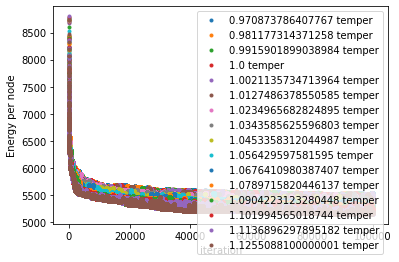

In [13]:
x=np.arange(PasosMC)
for k_nt in range(0,N_t):
    energies_pasos_temper = energies_pasos[k_nt,:] 
    plt.plot(x,energies_pasos_temper,'.',label='%s temper' % tempers[k_nt])
    plt.xlabel('iteration')
    plt.ylabel('Energy per node')
plt.legend()
plt.show()

In [14]:
# Store in a dictionary
d_store={}
string = "emails_5links25year_noanchor_" + schosen + '_0.pickle'
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups

d_store["size_groups"] = size_groups
d_store["tempers"] = tempers
d_store["groups"] = groups_t

d_store["P_inter"] = P_intermediate_shot
d_store["E_inter"] = E_intermediate_shot
d_store["E_store"] = Energy_store
d_store["E_groundtruth"] = Energy_new
d_store["Pasos_corr_ini"] = Pasos_corr 
d_store["Step_corr"] = Long_corr

file1 = open(string,"wb")
pickle.dump( d_store, file1)


In [15]:
d_store={}
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups

d_store["size_groups"] = size_groups
d_store["tempers"] = tempers
d_store["groups"] = groups_t

d_store["P_inter"] = P_intermediate_shot
d_store["E_inter"] = E_intermediate_shot
d_store["E_store"] = Energy_store
# d_store["groups"] = groups_store
d_store["E_groundtruth"] = Energy_new
d_store["Pasos_corr_ini"] = Pasos_corr 
d_store["Step_corr"] = Long_corr

file1 = open(string,"wb")
pickle.dump( d_store, file1)
prueba = pickle.load(open(string, "rb"))